# Project: Real-Time Mask Detector (YOLOv4)

In this notebook, we will be building a program to detect whether a person is wearing a mask or not, i.e., a mask detector. The situation is as follows: we have a camera that records video of a very busy area (for example, the entrance of a shopping center, a school, etc.) and we want to detect in real time if someone is not wearing a mask in order to warn him or prevent him from passing. The "real-time" condition suggests using models that can perform this task in one-stage, such as YOLO, SSD or RetinaNet. However, two-stage models can still perform well, since the number of classes is not too high. In this project we will use YOLOs latest version, YOLOv4, as our detector.

This Colab Notebook is part of the post [Real-time object detection - YOLOv4
](https://mathchine-learning.blogspot.com/2020/10/real-time-object-detection-yolov4.html) from my blog [Mathchine Learning](https://mathchine-learning.blogspot.com/). I recommend reading the post before going any further in this notebook.

In case you are not interested in the model and the training process, you can directly skip to the Testing section to see our YOLOv4s Mask Detector in action. Although, you will miss a lot! 

## Table of contents
- [1.  Data in YOLOv4](#1)
    - [1.1  Understanding the data](#1.1)
    - [1.2  Loading the data](#1.2)
    - [1.3  MetaData](#1.3)
        - [1.3.1  Creating the MetaData files](#1.3.1)
        - [1.3.2  Processing the MetaData](#1.3.2)
        - [1.3.3  Conclusions about the MetaData](#1.3.3)
    - [1.4  Preprocessing](#1.4)    
        - [1.4.1  Convert labels to YOLOs format](#1.4.1)
        - [1.4.2  Copy the images](#1.4.2)    
    - [1.5  Data visualization](#1.5)
    - [1.6  Helper functions](#1.6)
- [2.  The model](#2)
    - [2.1  Cloning and building Darknet](#2.1)
    - [2.2  Downloading pretrained weights](#2.2)
    - [2.3  Configuration files](#2.3)
- [3.  Training](#3)
- [4.  Testing](#4)
    - [4.1  Fast setup (optional)](#4.1)
    - [4.2  Image detection](#4.2)
    - [4.3  Video detection](#4.3)
    - [4.4  Conclusion](#4.4)

<a name="1"></a>
# 1. Data in YOLOv4

<a name="1.1"></a>
## 1.1 Understanding the data

First, we will load the dataset we will use to train our model. The dataset is called [Face Mask Detection](https://www.kaggle.com/andrewmvd/face-mask-detection) and it was download to Kaggle by andrewmvd. 

The dataset contains 853 images labeled using the Pascal VOC format. In this format, there is one XML file for each image using the same name as the corresponding image file. The XML file contains the description of the bounding boxes, together with the class associated to each bounding box. Hence, in our case, we have also 853 XML files containing the bounding boxes that indicate where the head of each individual is located on its corresponding image and a class assigned according to whether the individual is using a mask, is not using it or is using it incorrectly.

Let's see an example of a pair (image, label). Here is the image:

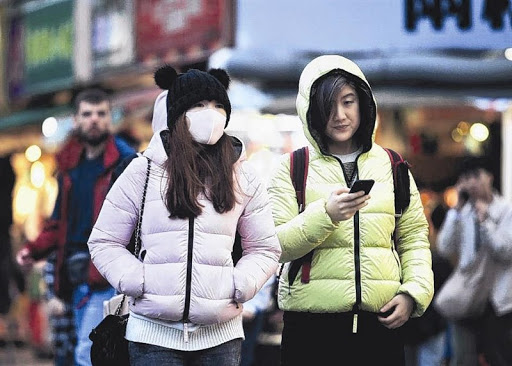

And here is its corresponding XML file.

```
<annotation>
    <folder>images</folder>
    <filename>maksssksksss0.png</filename>
    <size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>325</xmin>
            <ymin>90</ymin>
            <xmax>360</xmax>
            <ymax>141</ymax>
        </bndbox>
    </object>
</annotation>
```



As you can see, there is not only information about the objects. It also contains some general information like the size of the image.

Unfortunately, neither YOLO nor any other known object detection model uses this format. Therefore, once we have downloaded the database, we will have to preprocess the labels.

<a name="1.2"></a>
## 1.2 Loading the data

In this section, we are downloading the data from Kaggle. To do that, follow these steps: 
*   Log in to your Kaggle account.
*   Go to "My account" and create a new API token.
*   You will get a json file, open it and copy the username and the key and past them in the code below.

In [ ]:
# Configuration environment
from IPython.display import clear_output  
import os

# Copy the username and key from the json file.
os.environ['KAGGLE_USERNAME'] = "" # username from the json file
os.environ['KAGGLE_KEY'] = "" # key from the json file

# Download the Face Mask Detection dataset from Kaggle
!kaggle datasets download -d andrewmvd/face-mask-detection

clear_output()
print('Face Mask Detection dataset downloaded.')

Face Mask Detection dataset downloaded.


We will also create the directory structure for the project:

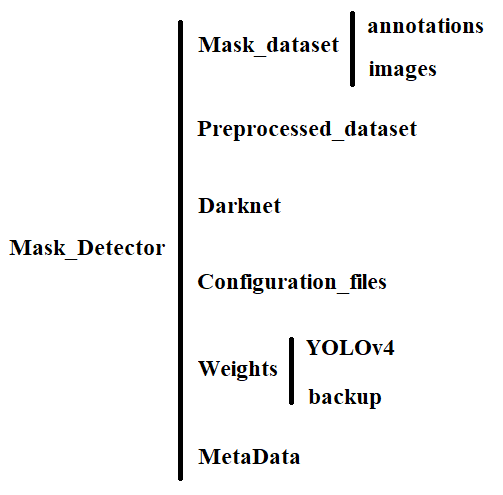


In [ ]:
pathMaskDetector = os.path.join('/content', 'Mask_Detector')
os.mkdir(pathMaskDetector)

pathMaskdataset = os.path.join(pathMaskDetector, 'Mask_dataset')
os.mkdir(pathMaskdataset)

pathPreprocesseddataset = os.path.join(pathMaskDetector, 'Preprocessed_dataset')
os.mkdir(pathPreprocesseddataset)

pathDarknet = os.path.join(pathMaskDetector, 'Darknet')
os.mkdir(pathDarknet)

pathConfigurationfiles = os.path.join(pathMaskDetector, 'Configuration_files')
os.mkdir(pathConfigurationfiles)

pathWeights = os.path.join(pathMaskDetector, 'Weights')
os.mkdir(pathWeights)

pathMetaData = os.path.join(pathMaskDetector, 'MetaData')
os.mkdir(pathMetaData)

Finally, we will unzip the data in its corresponding directory.

In [ ]:
# Unzip the file
!unzip face-mask-detection.zip -d Mask_Detector/Mask_dataset

clear_output()
print('Face Mask Detection dataset uncompressed.')

Face Mask Detection dataset uncompressed.


<a name="1.3"></a>
## 1.3 MetaData


Before we start with the database preprocessing, let's see what we have here. In this section, we will see general but relevant information about the dataset, such as how many bounding boxes we have of each class or where in the image these boxes are usually located. To do that, we will need the following libraries.

In [ ]:
# Importing libraries
import numpy as np
!pip install xmltodict
import xmltodict
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the pathes
pathimages = os.path.join(pathMaskdataset, 'images')
pathannotations = os.path.join(pathMaskdataset, 'annotations')

<a name="1.3.1"></a>
### 1.3.1 Creating the MetaData files

First, we create two lists of file names, one for the images and one for the XMLs files.

In [ ]:
# File names
imageFilesNames = []  # List of imagefile names
labelFilesNames = []  # List of xmlfile names

for dirpath, dirnames, filenames in os.walk(pathMaskdataset):
    for filename in filenames:
        if filename[-3:] == "xml":
            labelFilesNames.append(filename)
        elif filename[-3:] == "png":
            imageFilesNames.append(filename)

['maksssksksss321.png', 'maksssksksss416.png', 'maksssksksss389.png', 'maksssksksss549.png', 'maksssksksss665.png', 'maksssksksss819.png', 'maksssksksss88.png', 'maksssksksss274.png', 'maksssksksss443.png', 'maksssksksss160.png', 'maksssksksss210.png', 'maksssksksss253.png', 'maksssksksss607.png', 'maksssksksss385.png', 'maksssksksss380.png', 'maksssksksss11.png', 'maksssksksss615.png', 'maksssksksss92.png', 'maksssksksss598.png', 'maksssksksss185.png', 'maksssksksss295.png', 'maksssksksss154.png', 'maksssksksss289.png', 'maksssksksss831.png', 'maksssksksss768.png', 'maksssksksss309.png', 'maksssksksss414.png', 'maksssksksss762.png', 'maksssksksss19.png', 'maksssksksss502.png', 'maksssksksss107.png', 'maksssksksss753.png', 'maksssksksss811.png', 'maksssksksss650.png', 'maksssksksss847.png', 'maksssksksss722.png', 'maksssksksss691.png', 'maksssksksss409.png', 'maksssksksss609.png', 'maksssksksss39.png', 'maksssksksss577.png', 'maksssksksss246.png', 'maksssksksss356.png', 'maksssksksss56

Now, we will use the information that can be obtained from the XML files to create two csv files with some general information:
*   The first csv file will contain information about the images, such as its filename, its size or whether it is segmented or not.
*   The second csv file will contain information about the objects (bounding boxes), such as its label, its corresponding filename, its coordinates, etc.



In [ ]:
# We create the images csv file
pathmetaDataImgs = os.path.join(pathMetaData, 'metaDataImgs.csv')

metaDataImgs = open(pathmetaDataImgs, "w+")

# We create the objects csv file
pathmetaDataObjs = os.path.join(pathMetaData, 'metaDataObjs.csv')

metaDataObjs = open(pathmetaDataObjs, "w+")

# We create the headers for both files
metaDataImgs.write('id_,'+ 'filename,' + 'width,' + 'height,' + 'depth,' + 'segmented' + '\n')

metaDataObjs.write('id_,' + 'label,' +'filename,' + 'x1,' + 'y1,' + 'x2,' + 'y2,' + 'pose,' + 'truncated,' + 'occluded,' + 'difficult' + '\n')


id_Objs = -1

# Now, we loop through the XML files
for id_Imgs, filename in enumerate(labelFilesNames):
    pathLabel = os.path.join(pathannotations, filename)


    with open(pathLabel) as fxml:

        # We convert the XML file into a python dictionary
        fdict = xmltodict.parse(fxml.read())

        # For each file we save the following parameters
        width = fdict['annotation']['size']['width']  # Image width
        height = fdict['annotation']['size']['height']  # Image height
        depth = fdict['annotation']['size']['depth']  # Image depth
        segmented = fdict['annotation']['segmented']  # Whether it is segmented or not

        # Then, we write these parameters in the file
        metaDataImgs.write(str(id_Imgs) + ',' + filename + ',' + width + ',' + height + ',' + depth + ',' + segmented + '\n')

        objects = fdict['annotation']['object']

        # Now, for each object found in the XML
        if type(objects) == list:
            for counter, object in enumerate(objects):
                id_Objs += 1

            # We save the following parameters
                objLabel = object['name']  # Object label

                x1 = object['bndbox']['xmin']  # Object xmin
                x2 = object['bndbox']['xmax']  # Object xmax
                y1 = object['bndbox']['ymin']  # Object ymin
                y2 = object['bndbox']['ymax']  # Object ymax

                pose = object['pose']  # Object pose
                truncated = object['truncated']  # Whether the object is truncated or not
                occluded = object['occluded']  # Whether the object is occluded or not
                difficult = object['difficult']  # From a scale, how difficult it is to identify the object
       
           # Then, we write these parameters in the file
                metaDataObjs.write(str(id_Objs) + ',' + objLabel + ',' + filename + ',' + x1 + ',' + y1 + ',' + x2 + ',' + y2 + ',' + pose
                                   + ',' + truncated + ',' + occluded + ',' + difficult + '\n')
        else:
            id_Objs +=1

            objLabel = objects['name']

            x1 = objects['bndbox']['xmin']
            x2 = objects['bndbox']['xmax']
            y1 = objects['bndbox']['ymin']
            y2 = objects['bndbox']['ymax']

            pose = objects['pose']
            truncated = objects['truncated']
            occluded = objects['occluded']
            difficult = objects['difficult']

            metaDataObjs.write(str(id_Objs) + ',' + objLabel + ',' + filename + ',' + x1 + ',' + y1 + ',' + x2 + ',' + y2 + ',' + pose
                                   + ',' + truncated + ',' + occluded + ',' + difficult + '\n')

metaDataImgs.close()
metaDataObjs.close()

<a name="1.3.2"></a>
### 1.3.2 Processing the MetaData

In this section we are using use pandas in order to preprocess the MedaData we just created. 

In [ ]:
# We read both csv files
dfImgs = pd.read_csv(pathmetaDataImgs)
dfObjs = pd.read_csv(pathmetaDataObjs)

In [ ]:
# Get a description of the images df
dfImgs.describe()

,id_,width,height,depth,segmented
count,853.000000,853.000000,853.000000,853.0,853.0
mean,426.000000,370.589683,309.289566,3.0,0.0
std,246.384185,56.224049,74.474840,0.0,0.0
min,0.000000,193.000000,156.000000,3.0,0.0
25%,213.000000,301.000000,254.000000,3.0,0.0
50%,426.000000,400.000000,280.000000,3.0,0.0
75%,639.000000,400.000000,400.000000,3.0,0.0
max,852.000000,600.000000,600.000000,3.0,0.0


In [ ]:
# Since segmented column is just fill with zeros we are dropping it
dfImgs = dfImgs.drop('segmented', axis = 1)

# Also, since depth and id_ columns do not provide any addition information we will drop them too
dfImgs = dfImgs.drop('depth', axis = 1)
dfImgs = dfImgs.drop('id_', axis = 1)

dfImgs.head()

,filename,width,height
0,maksssksksss715.xml,267,400
1,maksssksksss129.xml,400,295
2,maksssksksss501.xml,400,255
3,maksssksksss381.xml,400,311
4,maksssksksss553.xml,301,400


In [ ]:
# Get a description of the objects df
dfObjs.describe()

,id_,x1,y1,x2,y2,truncated,occluded,difficult
count,4072.000000,4072.000000,4072.000000,4072.000000,4072.000000,4072.0,4072.0,4072.0
mean,2035.500000,182.207024,85.780697,213.356090,120.785609,0.0,0.0,0.0
std,1175.629477,104.471254,52.571821,102.712267,70.355098,0.0,0.0,0.0
min,0.000000,1.000000,1.000000,8.000000,6.000000,0.0,0.0,0.0
25%,1017.750000,96.000000,49.000000,134.000000,73.000000,0.0,0.0,0.0
50%,2035.500000,177.000000,75.000000,212.000000,103.000000,0.0,0.0,0.0
75%,3053.250000,266.000000,113.000000,292.000000,148.000000,0.0,0.0,0.0
max,4071.000000,569.000000,330.000000,592.000000,495.000000,0.0,0.0,0.0


In [ ]:
# Check if pose column contains any relevant information
# You can see the pose is unspecified for all the objects
dfObjs[dfObjs.pose != 'Unspecified']

,id_,label,filename,x1,y1,x2,y2,pose,truncated,occluded,difficult


In [ ]:
# As pose column is filled with "Unspecified" we will drop it, together with other irrelevant columns
dfObjs = dfObjs.drop(['id_', 'pose', 'truncated', 'occluded', 'difficult'], axis = 1)

dfObjs.head()

,label,filename,x1,y1,x2,y2
0,with_mask,maksssksksss715.xml,81,168,127,221
1,without_mask,maksssksksss715.xml,1,169,24,228
2,without_mask,maksssksksss129.xml,106,69,124,89
3,without_mask,maksssksksss129.xml,149,30,168,53
4,with_mask,maksssksksss129.xml,246,40,271,69


In [ ]:
# Now, merge both tables using the filename column
dfObjsm = pd.merge(dfObjs, dfImgs, on = 'filename')

dfObjsm.head()

,label,filename,x1,y1,x2,y2,width,height
0,with_mask,maksssksksss715.xml,81,168,127,221,267,400
1,without_mask,maksssksksss715.xml,1,169,24,228,267,400
2,without_mask,maksssksksss129.xml,106,69,124,89,400,295
3,without_mask,maksssksksss129.xml,149,30,168,53,400,295
4,with_mask,maksssksksss129.xml,246,40,271,69,400,295


In [ ]:
# We create new variables corresponding to the center of the bounding box
dfObjsm['center_x'] = (dfObjsm.x1 + dfObjsm.x2) // 2
dfObjsm['center_y'] = (dfObjsm.y1 + dfObjsm.y2) // 2

# We also create a normalized version of this variables
dfObjsm['norm_cx'] = dfObjsm.center_x / dfObjsm.width
dfObjsm['norm_cy'] = dfObjsm.center_y / dfObjsm.height


dfObjsm.head()

,label,filename,x1,y1,x2,y2,width,height,center_x,center_y,norm_cx,norm_cy
0,with_mask,maksssksksss715.xml,81,168,127,221,267,400,104,194,0.389513,0.485000
1,without_mask,maksssksksss715.xml,1,169,24,228,267,400,12,198,0.044944,0.495000
2,without_mask,maksssksksss129.xml,106,69,124,89,400,295,115,79,0.287500,0.267797
3,without_mask,maksssksksss129.xml,149,30,168,53,400,295,158,41,0.395000,0.138983
4,with_mask,maksssksksss129.xml,246,40,271,69,400,295,258,54,0.645000,0.183051


That should be enough to get some interesting insights about our data.

<a name="1.3.3"></a>
### 1.3.3 Conclusions about the MetaData

The following information can be obtained just by analyzing the metadata.

######  There are 853 images. In total, there are 4072 bounding boxes: 3232 for people with a mask, 717 for people without a mask, and 123 for people who use their mask incorrectly. The balance of the dataset is not the best, and in this case, it would be a good idea to obtain more samples from individuals without a mask or who use their mask incorrectly; however the purpose of this project is learning and we will accept this dataset as valid. Recall that YOLOv4 has data augmentation integrated, that will help alleviate these deficiencies


In [ ]:
print('The total amount of bounding boxes is', dfObjsm.shape[0]) 

print('There are', dfObjsm[dfObjsm['label'] == 'with_mask'].shape[0], 'individuals with mask')

print('There are', dfObjsm[dfObjsm['label'] == 'without_mask'].shape[0], 'individuals without mask')

print('There are', dfObjsm[dfObjsm['label'] == 'mask_weared_incorrect'].shape[0], 'individuals wearing their mask incorrectly')

The total amount of bounding boxes is 4072
There are 3232 individuals with mask
There are 717 individuals without mask
There are 123 individuals wearing their mask incorrectly


###### Images average size is (394, 270). Objects average size is (31, 35). Bounding boxes are quite small compared to the images size. Therefore, we can assume most of the images were taken from a considerable distance.

In [ ]:
print('The average image width is', dfObjsm.width.mean())

print('The average image height is', dfObjsm.height.mean())

The average image width is 393.70284872298623
The average image height is 270.1237721021611


In [ ]:
print('The average object width is', (dfObjsm.x2 - dfObjsm.x1).mean())

print('The average object height is', (dfObjsm.y2 - dfObjsm.y1).mean())

The average object width is 31.149066797642437
The average object height is 35.0049115913556


###### The objects locations are well distributed. There are no particular regions of the $[0, 1]\times [0, 1]$ without samples.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


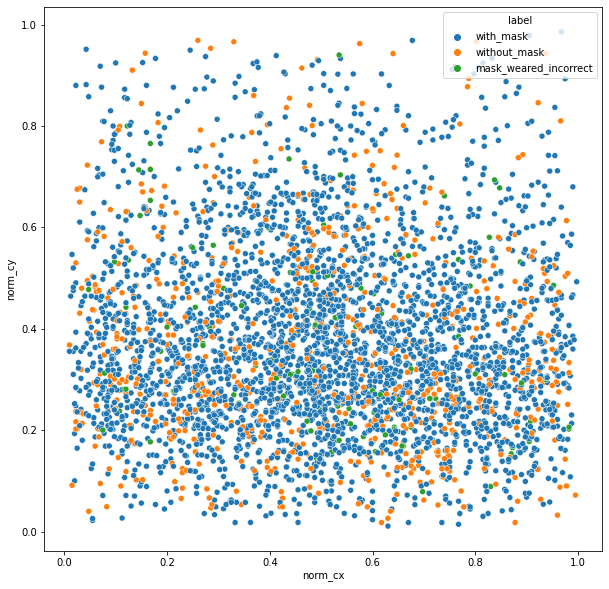

In [ ]:
# The following plot displays the objects normalized center
plt.figure(figsize=(10,10))
sns.scatterplot(dfObjsm.norm_cx, dfObjsm.norm_cy, dfObjsm.label)

<a name="1.4"></a>
## 1.4 Preprocessing

In this section, we are preparing the data for feeding YOLOs model. To do that, for every image in the dataset we have to create a txt file (with the same name as the image) containing the class id (in our case, it is 0 for with_mask, 1 for without_mask or 2 for mask_weared_incorrect) and the bounding box coordinates for every object in the image. For the previous example, its txt file would look like this:

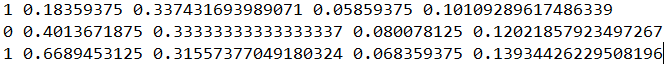

We have to put those txt files together with the images in the same directory. Thats exactly what we are doing in the following two subsections.

<a name="1.4.1"></a>
### 1.4.1 Convert labels to YOLOs format

In VOC PASCAL format, XML files use coordinates (xMin, xMax, yMin, yMax) for the bounding boxes (red parameters). Meanwhile, YOLO uses normalized (x, y, w, h) where x and y are the center coordinates of the bounding box and w and h are the width and height of the bounding box (green parameters). 


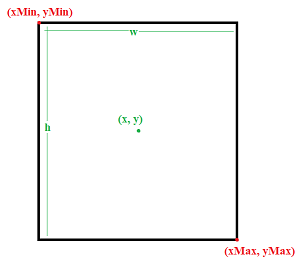

In [ ]:
# Labels conversion dictionary
# With mask = 0 = with_mask
# Without mask = 1 = without_mask
# Mask worn incorrectly = 2 = mask_weared_incorrect
dictLabels = {'with_mask': '0', 'without_mask': '1', 'mask_weared_incorrect': '2'}

# Loop through the XML files
for filename in labelFilesNames:

    with open(os.path.join(pathannotations, filename)) as fxml:

        pathWrite = os.path.join(pathPreprocesseddataset, filename[:-3] + 'txt')

        print(pathWrite)

        # Create a txt file with the same name as the XML file
        fYOLO = open(pathWrite, "w+")

        # Read the XML as a python dictionary
        fdict = xmltodict.parse(fxml.read())

        # Save Width and Height as we will use it later
        Width = float(fdict['annotation']['size']['width'])
        Height = float(fdict['annotation']['size']['height'])

        if type(fdict['annotation']['object']) == list:
            for counter, object in enumerate(fdict['annotation']['object']):

                # Save label, xMin, xMax, yMin, yMax
                fLabel = object['name']
                xMin = float(object['bndbox']['xmin'])
                xMax = float(object['bndbox']['xmax'])
                yMin = float(object['bndbox']['ymin'])
                yMax = float(object['bndbox']['ymax'])
                
                # Now, we create the variables we are going to write in the txt file
                label = dictLabels[fLabel]
                w = str((xMax - xMin) / Width)
                h = str((yMax - yMin) / Height)
                x = str(xMin / Width + (xMax - xMin) / Width / 2)
                y = str(yMin / Height + (yMax - yMin) / Height / 2)

                fYOLO.write(label + ' ' + x + ' ' + y + ' ' + w + ' ' + h)

                if counter < len(fdict['annotation']['object']) - 1:
                    fYOLO.write('\n')

        else:
            fLabel = fdict['annotation']['object']['name']
            xMin = float(fdict['annotation']['object']['bndbox']['xmin'])
            xMax = float(fdict['annotation']['object']['bndbox']['xmax'])
            yMin = float(fdict['annotation']['object']['bndbox']['ymin'])
            yMax = float(fdict['annotation']['object']['bndbox']['ymax'])

            label = dictLabels[fLabel]
            w = str((xMax - xMin) / Width)
            h = str((yMax - yMin) / Height)
            x = str(xMin / Width + (xMax - xMin) / Width / 2)
            y = str(yMin / Height + (yMax - yMin) / Height / 2)

            fYOLO.write(label + ' ' + x + ' ' + y + ' ' + w + ' ' + h)



        fYOLO.close()

clear_output()

<a name="1.4.2"></a>
### 1.4.2 Copy the images

Now, we include the images into the preprocessed dataset directory. Although it is not required because YOLOv4 does it by itself, we will also reshape the images to 640x640 size. A good practice is to use a multiple of 32 ([remember why?](https://mathchine-learning.blogspot.com/2020/10/real-time-object-detection-yolov2-and.html)).

In [ ]:
from PIL import Image
#Target sizes
WIDTH = 640
HEIGHT = 640

for filename in imageFilesNames:
    pathResizedImage = os.path.join(pathPreprocesseddataset, filename)
    print(pathResizedImage)
    img = Image.open(os.path.join(pathimages, filename))
    ResizedImage = img.resize((WIDTH, HEIGHT))
    ResizedImage.save(pathResizedImage)

clear_output()

<a name="1.5"></a>
## 1.5 Data visualization

Finally, the dataset is ready for YOLO, let's visualize some samples. We constructed a function to do that.

In [ ]:
import cv2
import random

from google.colab.patches import cv2_imshow

def drawObjects(fileName, classDict, colorDict, dir = pathPreprocesseddataset):

  """Draws the bounding boxes for the image in filename. 
     It assumes image and txt are both on the same dir.

  Args:
        filename (str): image filename without format
        classDict (dict): a dictionary with the classes as keys and the indices as values
        colorDict (dict): a dict with keys 'n' for n in class ids and values 
                          the corresponding BGR tuples assigned to class n
        dir (str): image directory
  Returns:
        np.array: image with bounding boxes
  """

  imgFile = os.path.join(dir, fileName)

  txtFile = os.path.join(dir, fileName[:-3] + 'txt')

  # Read the image
  img = cv2.imread(imgFile)

  invClassDict = {v: k for k, v in classDict.items()}

  # Read the txt
  with open(txtFile, 'r') as f:

    txt = f.read().split('\n')
    
    # Loop through the bounding boxes
    for bbox in txt:
      bbox = bbox.split()
      
      # Save the class
      classID = bbox[0]
      # Save the coordinates
      x = float(bbox[1])
      y = float(bbox[2])
      w = float(bbox[3])
      h = float(bbox[4])

      # opencv uses (xMin, xMax, yMin, yMax) coordinates for its draw functions
      xMin = int((x - w / 2) * img.shape[0])
      xMax = int((x + w / 2) * img.shape[0])
      yMin = int((y - h / 2) * img.shape[1])
      yMax = int((y + h / 2) * img.shape[1])
      
      # Draw a rectangle
      imgResult = cv2.rectangle(img, (xMin, yMin), (xMax, yMax), colorDict[classID], 2)

      # Write label
      imgResult = cv2.putText(img,
                 invClassDict[classID], 
                 (xMin - 3, yMin -4), 
                 cv2.FONT_HERSHEY_SIMPLEX, 
                 0.6,
                 colorDict[classID],
                 1)

  return imgResult

Run the cell below several times to visualize different samples.

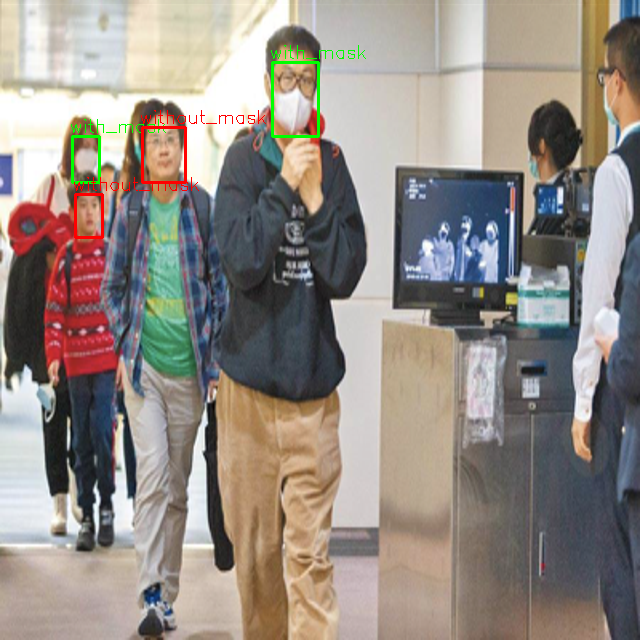

In [ ]:
# Pick a  random sample
randomSample = random.randint(0, len(imageFilesNames))
fileName = imageFilesNames[randomSample]

# We define the colorDict
# with_mask = Green
# without_mask = Red
# mask_weared_incorrect = Blue
colorDict = {'0': (0, 255, 0), '1': (0, 0, 255), '2': (255, 0, 0)}

# Draw the bounding boxes
imgResult = drawObjects(fileName, dictLabels, colorDict)

# Display the result
cv2_imshow(imgResult)

<a name="1.6"></a>
## 1.6 Helper functions

These three functions are helper functions that will allow us to show the image in Colab Notebook, as well as upload and download images to and from your Cloud VM.

In [ ]:
# Show image
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# Upload images
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# Download images
def download(path):
  from google.colab import files
  files.download(path)

<a name="2"></a>
# 2. The model

<a name="2.1"></a>
## 2.1 Cloning and building Darknet

First, we will clone Darknet from Alexey Bochkovskiy repository, adjust the settings in order to use opencv and gpu and build Darknet.

In [ ]:
# Clone Darknet from AlexeyAB repository
!git clone https://github.com/AlexeyAB/darknet /content/Mask_Detector/Darknet

# Adjust  Makefile to have opencv and gpu enabled
%cd /content/Mask_Detector/Darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

# Build Darknet
!make

%cd /content

clear_output()

<a name="2.2"></a>
## 2.2 Downloading pretrained weights 

As you may recall from [the post](https://mathchine-learning.blogspot.com/2020/10/real-time-object-detection-yolov4.html),  YOLOv4 has been trained already on the MS COCO dataset, which has 80 classes. We will use these pretrained weights for transfer learning in order to train our mask detector later.

In this project, we will use YOLOv4-tiny network, a much faster object detector especially useful if you have limited compute resources in either training or deployment (in our particular case, we will probably run our mask detector on a raspberry or equivalent). It trades off performance for speed.

The main difference between YOLOv4-tiny and YOLOv4 is that the network size is drastically reduced: the number of convolutional layers in the CSP backbone is compressed, the number of stages is two instead of three and there are fewer anchor boxes. You can see the differences between the two networks by yourself in the config files:

*   [YOLOv4 tiny config](https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4-tiny.cfg)
*   [YOLOv4 config](https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4.cfg)

In [ ]:
# Download pre-trained weights for the convolutional layers and put to the directory build\darknet\x64
# YOLOv4 weights
# !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137 -P /content/Mask_Detector/Weights/YOLOv4

# YOLOv4 tiny weights
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29 -P /content/Mask_Detector/Weights/YOLOv4

clear_output()

<a name="2.3"></a>
## 2.3 Configuration files

Finally, we have to prepare the configuration files that YOLOv4 needs to train our mask detector. 

#### Generating train_data.txt, test_data.txt and val_data.txt

First configuration files needed are the train_data.txt, test_data.txt and val_data.txt files which hold the relative paths to all our training, test and validation images. These txt files look like this:

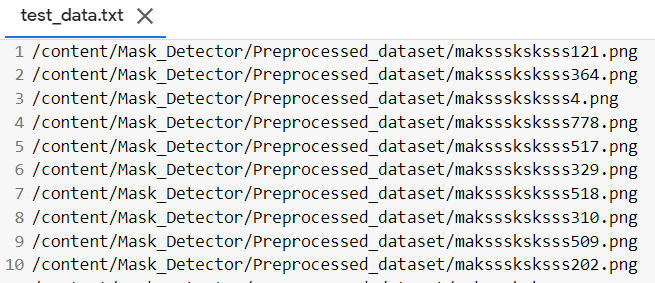

These files purpose is telling YOLOv4 where it can find the training, validation and test images.

The following code creates those files for us. Recall that best practice is using 70% of the data for the training set, 20% for the validation set, and 10 % for the testing set.

In [ ]:
# Shuffle the imageFilesNames
samplesCount = len(imageFilesNames)

random.shuffle(imageFilesNames)


# Split the images in train, validation and test dataset
trainSetNames = imageFilesNames[:int(samplesCount * 0.70)]  # 70% for train
valSetNames = imageFilesNames[int(samplesCount * 0.70):int(samplesCount * 0.90)]  # 20% for validation
testSetNames = imageFilesNames[int(samplesCount * 0.90):]  # 10% for test

# Create the pathes for train_data.txt, val_data.txt and test_data.txt
pathTrainSet = os.path.join(pathConfigurationfiles, 'train_data.txt')

pathValSet = os.path.join(pathConfigurationfiles, 'val_data.txt')

pathTestSet = os.path.join(pathConfigurationfiles, 'test_data.txt')

# Write the image pathes into the files
with open(pathTrainSet, "w+") as f:
    for sample in trainSetNames:
        f.write(os.path.join(pathPreprocesseddataset, sample) + '\n')

with open(pathTestSet, "w+") as f:
    for sample in testSetNames:
        f.write(os.path.join(pathPreprocesseddataset, sample)+ '\n')

with open(pathValSet, "w+") as f:
    for sample in valSetNames:
        f.write(os.path.join(pathPreprocesseddataset, sample) + '\n')

#### Classes.txt

YOLO also needs a txt file containing the names of the classes in order.

In [ ]:
pathClasses = os.path.join(pathConfigurationfiles, 'Classes.txt')

with open(pathClasses, "w+") as f:
  for classes in dictLabels.keys():
    f.write(classes + '\n')

As a result we obtain a txt file with the following:

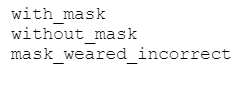

#### Config file

We have to select the configuration related to YOLOs architecture and YOLOs training.

In [ ]:
# In the first place, copy yolov4-custom.cfg into our Configuration files directory
!cp /content/Mask_Detector/Darknet/cfg/yolov4-tiny-custom.cfg /content/Mask_Detector/Configuration_files

In the second place, we edit the cfg file changing the following the authors recommendations:
- Set width/height = 640 (these can be any multiple of 32)
- max_batches = (# of classes) * 2000. In our case, 6000.
- steps = (80% of max_batches), (90% of max_batches). In our case, 4800, 5400.
- classes = (# of classes) in both YOLO layers. In our case, 3.
- filters = (# of classes + 5) * 3 in the convolutional layers previous to the YOLO layers. In our case, 24.

#### obj.names

YOLO also needs a file called obj.names where we will have one class name per line in the same order as our classes.txt.

In [ ]:
pathobjnames = os.path.join(pathConfigurationfiles, 'obj.names')

with open(pathobjnames, "w+") as f:
  for classes in dictLabels.keys():
    f.write(classes + '\n')

#### obj.data

Finally, obj.data file tells YOLO where it can find every the txt files and the obj.names.

In [ ]:
pathobjdata = os.path.join(pathConfigurationfiles, 'obj.data')

os.mkdir(os.path.join(pathWeights, 'backup'))

objdatastr = "# train and val datasets (image directory or *.txt file with image paths)" + "\n" + \
"train = " + pathTrainSet + "\n" + \
"valid = " + pathValSet + "\n" + \
"test = " + pathTestSet + "\n" + \
"# number of classes" + "\n" + \
"classes = 3" + "\n" + \
"# class names" + "\n" + \
"names = " + pathobjnames + "\n" +\
"# backup path" + "\n" + \
"backup = " + pathWeights + '/backup'

with open(pathobjdata, "w+") as f:
    f.write(objdatastr)

This backup path is where we will save the weights of our model throughout training. 

Finally, we can start training our mask detector.

<a name="3"></a>
# 3. Training

It is time to to train our mask detector. To do that we have to run the following command.

```
!./darknet detector train <path to obj.data> <path to custom config> <path to weights> -dont_show -map
```

(-dont_show flag stops chart from popping up since Colab Notebook can not open images on the spot, -map flag overlays mean average precision on chart to see how accuracy of your model is)

**TRAINING TIP 1:** This training could take several hours. However, Colab Cloud Service kicks you off its VMs if you are idle for too long (30-90 mins). To avoid this hold (CTRL + SHIFT + i)  to open up the inspector view on your browser.

Paste the following code into your console window and hit Enter.
```
function ClickConnect(){
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect,60000)
```
It will click the screen every 10 minutes so that you do not get kicked off.

**TRAINING TIP 2:** During training you can open the chart in the following link to see how it is going.
```
/content/Mask_Detector/Darknet/chart.png
```

In [ ]:
# Start training 
%cd /content/Mask_Detector/Darknet
!./darknet detector train /content/Mask_Detector/Configuration_files/obj.data /content/Mask_Detector/Configuration_files/yolov4-tiny-custom.cfg /content/Mask_Detector/Weights/YOLOv4/yolov4-tiny.conv.29 -dont_show -map

After training for several hours, we got our mask detector.

The following graph shows our models loss and mAP. 
*   As we can see, our loss goes below 2 after 600 iterations and below 0.5 after ~3500. That is pretty good, a YOLO custom detector can be considered good if its loss is lower than 2.
*   Our models mAP is around 85%, which can also be considered good for a super fast model, like yolov4-tiny.

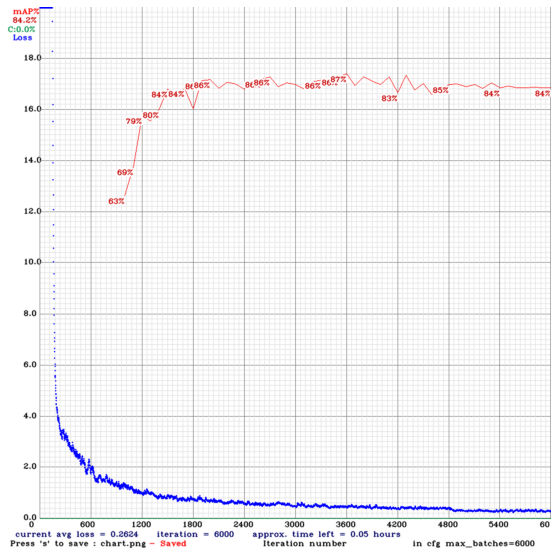

In [ ]:
# show chart.png of how custom object detector did with training
imShow('/content/Mask_Detector/Darknet/chart.png')

Since the results are pretty good, we will download the models weights.

In [ ]:
# Download just the weights
download('/content/Mask_Detector/Weights/backup/yolov4-tiny-custom_best.weights')

# Download the whole Mask_Detector
# !zip -r ./Mask_Detector.zip ./Mask_Detector
# download('/content/Mask_Detector.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<a name="4"></a>
# 4. Testing

In this section, we will test our model. First, we will download the pretrained weights (just in case you did not train the model, otherwise you can use your own weights). After that, we will test our model on images and videos.

<a name="4.1"></a>
## 4.1 Fast setup (optional)

In case you decided to skip directly to the Testing section, please run the following cell to download the pretrained mask detector model from our github respository.

In [ ]:
# Clone our GitHub repository
!git clone https://github.com/amirferoua/Project-Real-Time-Mask-Detector-YOLOv4 Mask_Detector
# Clone our Darknet repository
!git clone https://github.com/AlexeyAB/darknet Mask_Detector/Darknet

Cloning into 'Mask_Detector'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 24 (delta 3), reused 17 (delta 1), pack-reused 0
Unpacking objects: 100% (24/24), done.
Cloning into 'Mask_Detector/Darknet'...
remote: Enumerating objects: 14358, done.
remote: Total 14358 (delta 0), reused 0 (delta 0), pack-reused 14358
Receiving objects: 100% (14358/14358), 13.06 MiB | 24.50 MiB/s, done.
Resolving deltas: 100% (9765/9765), done.


In [ ]:
from IPython.display import clear_output  

# Adjust  Makefile to have opencv and gpu enabled
%cd /content/Mask_Detector/Darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

# Build Darknet
!make

%cd /content

clear_output()

Define some helper functions

In [ ]:
# Show image
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# Upload images
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# Download images
def download(path):
  from google.colab import files
  files.download(path)

Set our model to evaluation mode.

In [ ]:
# Set cfg file to test mode 
%cd /content/Mask_Detector/Configuration_files
!sed -i 's/batch=64/batch=1/' yolov4-tiny-custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-tiny-custom.cfg
%cd ..

# Set cfg file to train mode 
# %cd /content/Mask_Detector/Configuration_files
# !sed -i 's/batch=1/batch=64/' yolov4-tiny-custom.cfg
# !sed -i 's/subdivisions=1/subdivisions=16/' yolov4-tiny-custom.cfg
# %cd ..

/content/Mask_Detector/Configuration_files
/content/Mask_Detector


<a name="4.2"></a>
## 4.2 Image detection

Now, run detection on an image using the best weights we got after training YOLOv4-tiny.

--2020-10-27 16:19:22--  https://c8.alamy.com/comp/2CEGM2R/students-queuing-at-the-school-entrance-wearing-mask-face-to-prevent-infection-or-respiratory-illness-turin-italy-september-2020-2CEGM2R.jpg
Resolving c8.alamy.com (c8.alamy.com)... 52.9.170.225, 52.52.162.93
Connecting to c8.alamy.com (c8.alamy.com)|52.9.170.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘/content/sample.jpg’

/content/sample.jpg     [ <=>                ] 166.55K  --.-KB/s    in 0.1s    

Last-modified header invalid -- time-stamp ignored.
2020-10-27 16:19:23 (1.16 MB/s) - ‘/content/sample.jpg’ saved [170551]

/content/Mask_Detector/Darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input          

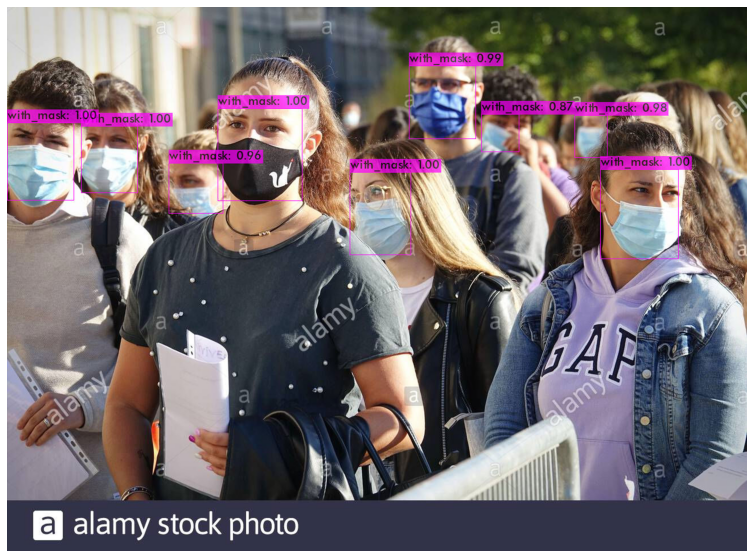

In [ ]:
from IPython.display import clear_output
# Get an image from a URL:
# !wget url sample
!wget https://c8.alamy.com/comp/2CEGM2R/students-queuing-at-the-school-entrance-wearing-mask-face-to-prevent-infection-or-respiratory-illness-turin-italy-september-2020-2CEGM2R.jpg -O /content/sample.jpg

# Upload an image from local
# upload()

%cd /content/Mask_Detector/Darknet
!./darknet detector test /content/Mask_Detector/Configuration_files/obj.data \
 /content/Mask_Detector/Configuration_files/yolov4-tiny-custom.cfg \
 /content/Mask_Detector/Weights/backup/yolov4-tiny-custom_best.weights \
 -dont_show \
 /content/sample.jpg -thresh 0.4

# clear_output()

imShow('predictions.jpg')

<a name="4.3"></a>
## 4.3 Video detection

A sample video can be downloaded from [this link](https://drive.google.com/file/d/1E_N0EwPM4wkTMtLewex0einuySDrgGiK/view?usp=sharing). Upload it to Colab and run the following command.

In [ ]:
from IPython.display import clear_output

%cd /content/Mask_Detector/Darknet
!./darknet detector demo /content/Mask_Detector/Configuration_files/obj.data \
 /content/Mask_Detector/Configuration_files/yolov4-tiny-custom.cfg \
 /content/Mask_Detector/Weights/backup/yolov4-tiny-custom_best.weights \
 -dont_show \
 /content/mask_detector_video.mp4 -thresh 0.4 -out_filename /content/results.mp4


# clear_output()

# !nvidia-smi

While running detection on a video, YOLOv4 shows the average FPS (frames per second) which is 44.2 with Tesla T4 GPU (~1800€). Keep in mind that anything greater than 30 FPS per second can be considered real time.

In order to see the results, you have to download the video in /content/results.mp4. 

You can also watch our results [here](https://www.youtube.com/watch?v=9H-gwxjUjyk&feature=youtu.be), if you prefer.

As you can see, our mask detector is not perfect, but it still does pretty decent. Keep in mind this video contains really hard scenarios, like for example people behind glass (on the bus). In our use case, we will not have this type of obstacle and the video camera will be strategically positioned to take the images from the best possible angle.

Here is a [second video](https://drive.google.com/file/d/1GTyPQUpYNfEOGZo5QNMx5_gwWb2hh7Pz/view?usp=sharing), this one is more related to the use case.

In [ ]:
from IPython.display import clear_output

%cd /content/Mask_Detector/Darknet
!./darknet detector demo /content/Mask_Detector/Configuration_files/obj.data \
 /content/Mask_Detector/Configuration_files/yolov4-tiny-custom.cfg \
 /content/Mask_Detector/Weights/backup/yolov4-tiny-custom_best.weights \
 -dont_show \
 /content/COVID_schools.mp4 -thresh 0.4 -out_filename /content/resultsschools.mp4

# clear_output()


You can watch the results [here](https://youtu.be/9Jz8vWo2nu4).

<a name="4.4"></a>
## 4.4 Conclusion

We have built a real-time mask detector using YOLOv4. Our database was not the best, however, we have obtained a good detector that runs at about 45 FPS on a relatively cheap GPU, has a very low loss and a mean average precision of over 80%.

In future projects, we will build a similar detector using YOLOv5 in order to compare both and decide which of the two does better.